In [1]:
pip install --quiet pip pillow tqdm opencv-python imutils scikit-image

Note: you may need to restart the kernel to use updated packages.


## 1 - generate training data with opencv

(Filtered) dice images dataset: https://paste.madflex.de/AYVYnadC/+inline 

In [2]:
!ls -1 /data/dice-mfa-blue-good/train | head -n 10

G010001_720p.png
G010002_720p.png
G010003_720p.png
G010004_720p.png
G010005_720p.png
G010006_720p.png
G010007_720p.png
G010008_720p.png
G010009_720p.png
G010011_720p.png
ls: write error: Broken pipe


In [3]:
import numpy as np
import cv2
import imutils
from matplotlib import pyplot as plt

In [4]:
img_name = "/data/dice-mfa-blue-good/train/G010006_720p.png"

the color palette is different in opencv (BGR instead of RGB)

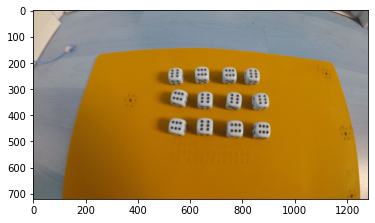

In [5]:
img = cv2.imread(img_name)
plt.imshow(img)

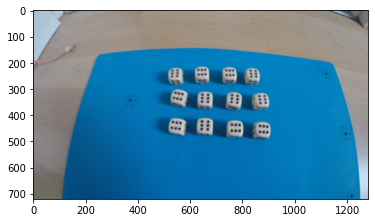

In [6]:
img = cv2.imread(img_name)
image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)

## opencv findContours

code used from here: https://pyimagesearch.com/2015/11/02/watershed-opencv/

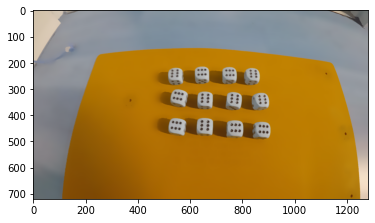

In [7]:
shifted = cv2.pyrMeanShiftFiltering(img, 10, 30)
plt.imshow(shifted)

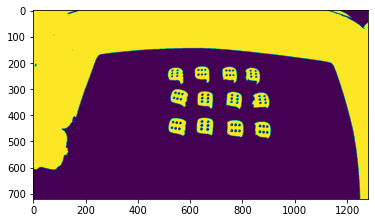

In [8]:
gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
plt.imshow(thresh)

In [9]:
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

In [10]:
img = cv2.imread(img_name)
img.shape

(720, 1280, 3)

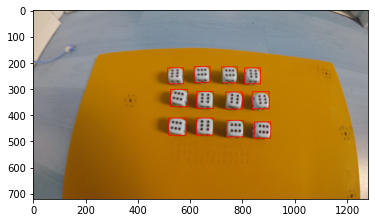

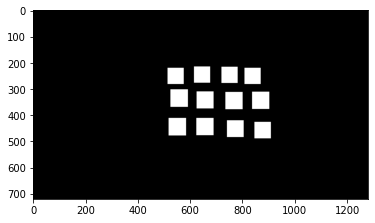

In [11]:
img = cv2.imread(img_name)
mask_img = np.zeros(img.shape[:2])
c_median = np.median([len(i) for i in cnts if len(i) > 2])
for (i, c) in enumerate(cnts):
    if len(c) < 0.5 * c_median or len(c) > 1.5 * c_median:
        continue
    if len(c) < 3:
        continue
    x1 = min([i[0][0] for i in c])
    x2 = max([i[0][0] for i in c])
    y1 = min([i[0][1] for i in c])
    y2 = max([i[0][1] for i in c])
    is_rectangle = ((x2-x1) / (y2-y1))
    if is_rectangle < 0.7 or is_rectangle > 1.3:
        continue
    mw_x, mw_y = (x2+x1)/2, (y1+y2)/2
    quad_len = max(x2-x1, y2-y1)
    cv2.rectangle(img, (int(mw_x-quad_len/2), int(mw_y-quad_len/2)),
                  (int(mw_x+quad_len/2), int(mw_y+quad_len/2)), (255, 0, 0), 2)
    # mask
    cv2.rectangle(mask_img, (int(mw_x-quad_len/2), int(mw_y-quad_len/2)),
                  (int(mw_x+quad_len/2), int(mw_y+quad_len/2)), (1), -1)
plt.imshow(img)
plt.show()
plt.imshow(mask_img, cmap='gray')
plt.show()

### process folder with all the images

this is done first for all the images; but only the "good" ones which were hand selected, are used later for training the UNet.

In [12]:
from pathlib import Path
from tqdm.notebook import tqdm

In [13]:
# to_path = Path("train_set-blue4")
# to_path = Path("RESULT_dice-mfa-blue-good/test")
to_path = Path("RESULT_dice-mfa-blue-good/train") 
_ = [(to_path / i).mkdir(parents=True, exist_ok=True) for i in ["debug", "masks"]]

In [14]:
# from_path = Path("dice-mfa-blue4")
# from_path = Path("/data/dice-mfa-blue-good/test")
from_path = Path("/data/dice-mfa-blue-good/train")
files = list(from_path.glob("*png"))
for fn in tqdm(files, total=len(files)):
    img = cv2.imread(str(fn))
    shifted = cv2.pyrMeanShiftFiltering(img, 10, 30)
    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    
    mask_img = np.zeros(img.shape[:2])
    c_median = np.median([len(i) for i in cnts if len(i) > 2])
    for (i, c) in enumerate(cnts):
        if len(c) < 0.5 * c_median or len(c) > 1.5 * c_median:
            continue
        if len(c) < 3:
            continue
        x1 = min([i[0][0] for i in c])
        x2 = max([i[0][0] for i in c])
        y1 = min([i[0][1] for i in c])
        y2 = max([i[0][1] for i in c])
        is_rectangle = ((x2-x1) / (y2-y1))
        if is_rectangle < 0.7 or is_rectangle > 1.3:
            continue
        mw_x, mw_y = (x2+x1)/2, (y1+y2)/2
        quad_len = max(x2-x1, y2-y1)
        # for debugging
        cv2.rectangle(img, (int(mw_x-quad_len/2), int(mw_y-quad_len/2)),
                      (int(mw_x+quad_len/2), int(mw_y+quad_len/2)), (0, 0, 255), 2)
        # mask
        cv2.rectangle(mask_img, (int(mw_x-quad_len/2), int(mw_y-quad_len/2)),
                      (int(mw_x+quad_len/2), int(mw_y+quad_len/2)), (1), -1)

    cv2.imwrite(f"{to_path}/debug/{fn.name}", img)
    cv2.imwrite(f"{to_path}/masks/{fn.name}", mask_img)

  0%|          | 0/836 [00:00<?, ?it/s]

### appendix

filter happened using https://github.com/mfa/image-tagger/   
screenshot:
![](https://paste.madflex.de/bECkTdeu/+inline)